Para todas as tarefas foi considerado uma resistência interna de $10~\mathrm{M}\Omega$ para o voltímetro, como diz no manual.<br>
ATENÇÃO: os valores de capacitância estão todos dados em micro Farad.

In [179]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats
from LabIFSC import M
from math import log10, floor

# Tarefa 1 - Analisar curva de carga de capacitores
Escolher três capacitores e analisar sua curva de carga com o objetivo de calcular sua capacitância pela curva.
## 1.1 Capacitores utilizados:
- $10~\mu\mathrm{F}$ (PARA O FINAL)
- $100~\mu\mathrm{F}$
- $220~\mu\mathrm{F}$
- $1000~\mu\mathrm{F}$

## 1.2 Esquema do circuito:
<img src="1.png" width="500px" />
## 1.3 Procedimento experimental:
Após montado o circuito acima, é fechado a chave e, ao mesmo tempo, disparado o cronômetro. Estes valores serão filmados com uma câmera de celular para ser feito a análise dos dados

## 1.4 Calculo da capacitância
Equação de carga de um capacitor:
$$V(t)=V_0(1-\mathrm{e}^{-t/RC})$$

Equação para regressão linear:
$$\log(V_0-V(t))=\log(V_0)-\dfrac{t}{RC}$$

### 1.4.1 Capacitor de 100uF

In [188]:
C1_tarefa1 = 10e-6
C2_tarefa1 = 100e-6
C3_tarefa1 = 220e-6
C4_tarefa1 = 220e-6

#############
Ri = 10e6
R100 = 102.6e3
R_carga = R100*Ri/(R100+Ri)
V0 = 4.48

round_to_1 = lambda x : round(x, -int(floor(log10(abs(x)))))

In [183]:
V0 = 4.48
err_v = lambda x : 0.005*x+0.03
err_r = lambda x : 0.005*x+300
err_t = lambda x : 0.05
err_y = lambda x : (err_v(V0)+err_v(x))/(V0-x)

modelo_carga = lambda tempo, cap: V0*(1-np.exp(-tempo/(R_carga*cap)))

807.7900738423773


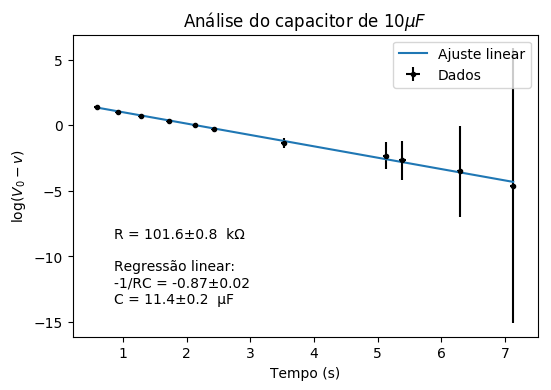

In [258]:
def analise_capacitor(CAPACITOR):
    t ,v = np.loadtxt("data/C{}.dat".format(CAPACITOR)).T
    slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = stats.linregress(t, np.log(V0-v))

    plt.figure(dpi=100)
    plt.plot(t, intercept_1 + t*slope_1, label="Ajuste linear")
    plt.errorbar(t,np.log(V0-v),xerr=err_t(t), yerr=err_y(v), fmt=".", color="k", label="Dados")
    plt.legend(loc=0)
    plt.title(r"Análise do capacitor de ${}\mu F$".format(CAPACITOR))
    plt.ylabel(r"$\log(V_0-v)$")
    plt.xlabel("Tempo (s)")

    slope_M = M((slope_1, std_err_1))
    R_carga_M = M((R_carga, err_r(R_carga)))
    print(err_r(R_carga))
    C1 = -1*(R_carga_M*slope_M)**(-1)

    plt.text(0.5+0.05*np.max(t),(np.min(np.log(V0-v))-np.max(err_y(v)))*0.9,"R = {} kΩ\n\nRegressão linear: \n-1/RC = {}\nC = {} µF".format(R_carga_M/1e3,slope_M,C1/1e-6))
    plt.savefig("analise/tarefa1_{}.png".format(CAPACITOR), dpi=300)
    
#     plt.figure(dpi=100)
#     plt.errorbar(t,v, fmt=" ", color="k", xerr=err_t(t), yerr=err_v(v), label="dados")
#     r = np.linspace(0,np.max(t),200)
#     plt.plot(r, modelo_carga(r,C1.nominal), label="Fitting")
#     plt.plot(r, r*0+V0, "--k")
#     plt.yticks([0,1,2,3,4,V0])
#     plt.xlim([0,np.max(t)])
#     plt.legend(loc=0)
#     plt.title("Fitting dos parâmetros encontrados")
#     plt.ylabel("Tensão (V)")
#     plt.xlabel("Tempo (s)")
analise_capacitor(10)

### 1.4.2 Capacitor de 220uF


Regressão linear: 

-1/RC = -0.04069961200774065
Capacitância = 244.39 uF


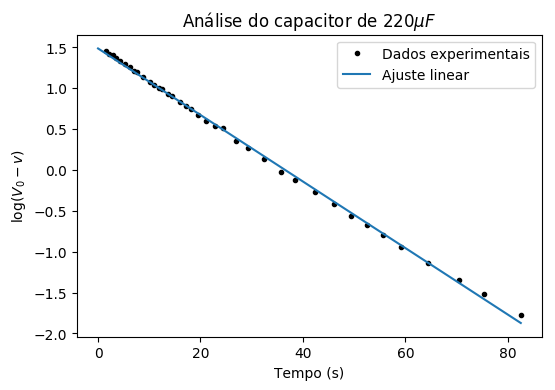

In [4]:
data100 = np.loadtxt("data/C220.dat").T
V0 = 4.48
modelo_carga = lambda cap, tempo: V0*(1-np.exp(-tempo*R_carga/cap))
v = data100[1] # tensao
t = data100[0] # tempo

slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = stats.linregress(t, np.log(V0-v))
plt.figure(dpi=100)
plt.plot(t, np.log(V0-v), 'k.', label="Dados experimentais")
x = np.linspace(0, t.max(), 200)
plt.title(r"Análise do capacitor de $220\mu F$")
plt.plot(x, intercept_1 + x*slope_1, label="Ajuste linear")
plt.legend(loc=0)
plt.ylabel(r"$\log(V_0-v)$")
plt.xlabel("Tempo (s)")
print("\nRegressão linear: \n")
C2 = -1e6/(R_carga*slope_1)
print("-1/RC = {}\nCapacitância = {:.2f} uF".format(slope_1, C2))

### 1.4.3 Capacitor de 1000uF


Regressão linear: 

-1/RC = -0.008879848141349216
Capacitância = 1120.13 uF


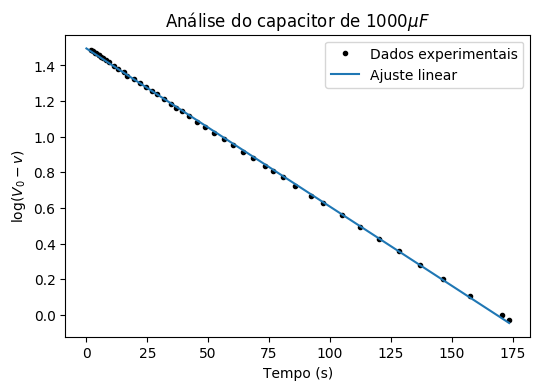

In [5]:
data100 = np.loadtxt("data/C1000.dat").T
V0 = 4.48
modelo_carga = lambda cap, tempo: V0*(1-np.exp(-tempo*R_carga/cap))
v = data100[1] # tensao
t = data100[0] # tempo

slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = stats.linregress(t, np.log(V0-v))
plt.figure(dpi=100)
plt.plot(t, np.log(V0-v), 'k.', label="Dados experimentais")
x = np.linspace(0, t.max(), 200)
plt.title(r"Análise do capacitor de $1000\mu F$")
plt.plot(x, intercept_1 + x*slope_1, label="Ajuste linear")
plt.legend(loc=0)
plt.ylabel(r"$\log(V_0-v)$")
plt.xlabel("Tempo (s)")
print("\nRegressão linear: \n")
C3 = -1e6/(R_carga*slope_1)
print("-1/RC = {}\nCapacitância = {:.2f} uF".format(slope_1, C3))

### 1.4.4 Capacitor de 10uF (DESAFIO)


Regressão linear: 

-1/RC = -0.8675244455246898
Capacitância = 11.47 uF

Pelo capacímetro deu 10,55 uF


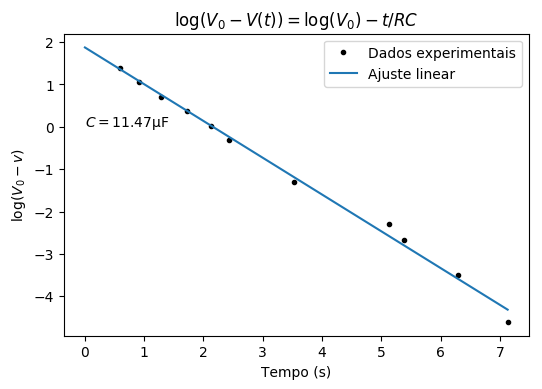

In [18]:
data100 = np.loadtxt("data/C10.dat").T
V0 = 4.48
modelo_carga = lambda cap, tempo: V0*(1-np.exp(-tempo*R_carga/cap))
v = data100[1] # tensao
t = data100[0] # tempo

slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = stats.linregress(t, np.log(V0-v))
plt.figure(dpi=100)
plt.plot(t, np.log(V0-v), 'k.', label="Dados experimentais")
x = np.linspace(0, t.max(), 200)
plt.title(r"$\log(V_0-V(t))=\log(V_0)-t/RC$")
plt.plot(x, intercept_1 + x*slope_1, label="Ajuste linear")
plt.legend(loc=0)
plt.ylabel(r"$\log(V_0-v)$")
plt.xlabel("Tempo (s)")
print("\nRegressão linear: \n")
CXD = -1e6/(R_carga*slope_1)
plt.text(0,0, r"$C={:.2f}$µF".format(CXD))
plt.savefig("twitter.png", dpi=300)
print("-1/RC = {}\nCapacitância = {:.2f} uF\n\nPelo capacímetro deu 10,55 uF".format(slope_1, CXD))

# Tarefa 2 - Analisar associação de capacitores
Analisar três associações de capacitores e como na primeira tarefa, obter suas curvas de carga para calcular suas capacitâncias e compara com o valor medido no capacimetro.

## 2.1 Capacitores utilizados:
- $100~\mu\mathrm{F}$
- $220~\mu\mathrm{F}$
- $1000~\mu\mathrm{F}$

In [7]:
print("Capacitores:\nC1 = {:.2f} uF\nC2 = {:.2f} uF\nC3 = {:.2f} uF".format(C1,C2,C3))

Capacitores:
C1 = 118.16 uF
C2 = 244.39 uF
C3 = 1120.13 uF


## 2.2 Procedimento experimental:
Medir a capacitância de cada circuito com um capacímetro e em seguida fazer a curva de carga de cada circuito, proceder como na tarefa 1.
### 2.2.1 Associação em série
$$\dfrac{1}{C}=\dfrac{1}{C_1}+\dfrac{1}{C_2}$$
<img src="2_serie.png" width="500px" />

In [8]:
C_serie = lambda C1, C2 : C1*C2/(C1+C2)
serie_esp = 68.75
serie_med = C_serie(C1, C2)
print("Valor esperado nominal: {} μF\nValor esperado pelas capacitancias:  {:.2f}μF".format(serie_esp, serie_med))

Valor esperado nominal: 68.75 μF
Valor esperado pelas capacitancias:  79.65μF


### 2.2.2 Associação em paralelo
$$C=C1+C2$$
<img src="2_paralela.png" width="500px" />

In [9]:
C_paralelo = lambda C1, C2 : C1+C2
paralelo_esp = 320
paralelo_med = C_paralelo(C1, C2)
print("Valor esperado nominal: {} μF\nValor esperado pelas capacitancias: {:.2f}μF".format(paralelo_esp, paralelo_med))

Valor esperado nominal: 320 μF
Valor esperado pelas capacitancias: 362.55μF


### 2.2.2 Associação mista
$$C=\dfrac{C_1(C_2+C_3)}{C_1+C_2+C_3}$$
<img src="2_mista.png" width="500px" />

In [10]:
C_mista = lambda C1, C2, C3 : C1*(C2+C3)/(C1+C2+C3)
mista_esp = 92.42
mista_med = C_mista(C1, C2, C3)
print("Valor esperado nominal: {} μF\nValor esperado pelas capacitancias: {}μF".format(mista_esp, mista_med))

Valor esperado nominal: 92.42 μF
Valor esperado pelas capacitancias: 108.74701223621685μF


# Tarefa 3 - Análise do produto RC
Analisar a variação no tempo de vida de um capacitor para uma associação de resistor com um capacitor.

Equação de descarga de um capacitor:
$$V(t)=V_0\mathrm{e}^{-t/RC}$$

Equação para regressão linear:
$$\log(V(t))=\log(V_0)-\dfrac{t}{RC}$$

## 3.1 Resistores utilizados:

- $100\mathrm{k}\Omega$
- $68\mathrm{k}\Omega$
- $47\mathrm{k}\Omega$
<br><br> E um capacitor de 220 uF

In [11]:
C_tarefa3 = C2
R1 = R100
R2 = 68.1e3
R3 = 47.8e3
print("C = {:.2f} uF\nR1 = {:.1f} kΩ\nR2 = {:.1f} kΩ\nR3 = {:.1f} kΩ".format(C_tarefa3, R1*1e-3, R2*1e-3, R3*1e-3))

C = 244.39 uF
R1 = 102.6 kΩ
R2 = 68.1 kΩ
R3 = 47.8 kΩ


## 3.2 Esquema do circuito
<img src="RC.png" width="500px" />

## 3.3 Procedimento experimental: 
Medir a resistência com um ohmimetro;<br> O capacitor é carregado;<br> Após montado o circuito acima, é fechado a chave e, ao mesmo tempo, disparado o cronômetro. Estes valores serão filmados com uma câmera de celular para ser feito a análise dos dados;

# Tarefa 4 - Análise da energia num circuito capacitivo
Calcular a energia inicial e final num circuito capacitivo.

## 4.1 Capacitores utilizados (C2)
C1 será fixo: $10.55~\mu\mathrm{F}$; Resistência associada: $100~\mathrm{k}\Omega$
- $1~\mu\mathrm{F}$ (capacimetro)
- $3,3~\mu\mathrm{F}$ (capacimetro)
- $10~\mu\mathrm{F}$ (capacimetro)
- $100~\mu\mathrm{F}$ (curva de carga)
- $220~\mu\mathrm{F}$ (curva de carga)

In [13]:
C2_fixo = 10.55e-6

## 4.2 Esquema do circuito
<img src="4.png" width="600px" />

## 4.3 Procedimento experimental


Medir a capacitância de C1 com um capacimetro; <br>
Carregar o capacitor com uma fonte de 5V;

In [14]:
C1_tarefa4 = C2_fixo

A energia inicial é dada por $\dfrac{1}{2}C_1\Delta V_i^2$

Desconsiderando dissipações pelas resistências, a energia final é $\dfrac{1}{2}(C_1+C_2)\Delta V_f^2$

In [15]:
Ei = lambda Vi : (1/2)*C1_tarefa4*Vi**2
Ef = lambda Vf, C2: (1/2)*(C1_tarefa4 + C2)*Vf**2

Com valores de energia inicial e final por capacitancia obtemos uma reta que relaciona estes valores


Regressão linear:
intercept: 0.8802834804931301, slope: 0.9646571372889399


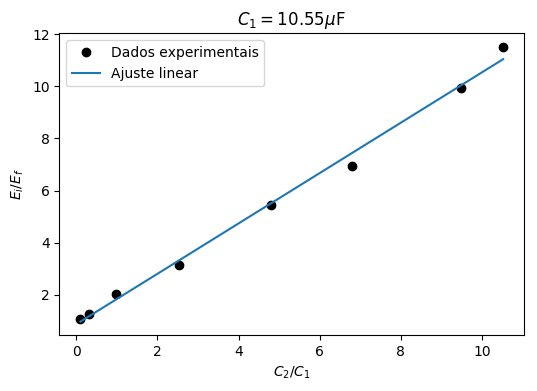

In [18]:
#x = np.array([C2_1, C2_2, C2_3, C2_4, C2_5])
data4 = np.loadtxt("data/energia.dat").T
C2 = data4[0]
Vi = data4[1]
Vf = data4[2]
slope, intercept, r_value, p_value, std_err = stats.linregress(C2/C1_tarefa4, Ei(Vi)/Ef(Vf, C2))
 

plt.figure(dpi= 100)
plt.xlabel(r"$C_2/C_1$")
plt.ylabel(r"$E_i/E_f$")
plt.title(r"$C_1={} \mu$F".format(C1_tarefa4*1e6))
plt.plot(C2/C1_tarefa4, Ei(Vi)/Ef(Vf, C2), "ko", label="Dados experimentais")
modelo = lambda x: intercept + slope*x
plt.plot(C2/C1_tarefa4, modelo(C2/C1_tarefa4), label="Ajuste linear")
plt.legend(loc=0)

print("\nRegressão linear:\nintercept: {}, slope: {}".format(intercept, slope))

<img src="4grafico.png" width="600px" style="float:left" />